# Featuring enginering for bag-of-words representation

### What you woul like to include:

- uni-grams DONE
- bi-grams DONE
- tri-grams DONE
- tf-idf (1,2,3 grams) DONE
- number of exclamation marks DONE - but not concatenated
- number of quesition marks DONE - but not concatenated
- number of @ DONE - but not concatenated
- number of # DONE - but not concatenated
---
- number of emojis
- Specific @'s and #'s as individual features
- Collections (of words that occure more often then random)
- Part-of-spech tagging (why thou?)

### how to reduce all that? DONE
- Forward selection w/ logistic regression or NB (the fasttest or the best) evaluated by F1 (or random forest if it is as fast... For interactions.)
- Backward selection w/ logistic regression or NB (the fastest or the best) evaluated by F1 (or random forest if it is as fast... For interactions.)

- Sklearn has a procidure for feature slecetions with trees through feature importance.... Hmm..

### What can exclude before F/B feature selection to minimize O: DONE
- High frequency stopwords
- low frequency rareties and clutter. 1 tweet?
- Number?

### What about tf-idf?: DONE
Can it just be seen as some weigted n-gram?


### And what about PCA's?
- These do belong in before the feature selections.
- But you cna easily set some threshold for explained variance
- But where.... Maybe.. Can I create PCA on sub sets.... looping over all 1, but only a comparable batch of 0.
- Btu there no security that you will identify the same PCA's each time..

### To undersample/over sample ot not to under/oversmpel... DONE
- Do oversmple..
- Do all three ting... Dne you need som very easily mentained functions.
- Starting with the under sampling, you allso get a felling of how long the feature selection will take
- Maybe you only undersample for the feature selection - if tit takes a long time. The do all three when you do the final test?
- But it should still be under 10000 obs if you oversample. Should not be a problem.

In [1]:
# Basics -----------------------------------------------------
import pickle

import numpy as np
import pandas as pd
from scipy import sparse

import matplotlib.pyplot as plt
import regex
import re


# NLTK -----------------------------------------------------

import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
#stop_words = set(nltk.corpus.stopwords.words("english"))

# Word2vec ----------------------------------------------------
import gensim

# SK learn --------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Sampling -------------------------------------------------

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler

# DATA ------------------------------------------------------
df = pd.read_csv("labled_tweets.csv", index_col=0)

# Split for inner and outer layer:

In [2]:
y = df["lacking_dem_pref"]
X = df["text"]

# Outer layer
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X, y, test_size=0.20, random_state=42)

# inner layer
X_train, X_test, y_train, y_test = train_test_split(X_train_out, y_train_out, test_size=0.20, random_state=42)


# Term document matrix:

### Preproccesing

In [3]:
def prep(text):
    wordlist = nltk.word_tokenize(text)
    wordlist = [lemmatizer.lemmatize(w.lower()) for w in wordlist]
    return wordlist

words = prep(df.text.to_string())
len(words)

57554

In [4]:
# For all text (why did you use wordF)
dist = nltk.FreqDist(words)
print("all tweets:")
print(dist.most_common(20))
print("\n","-------------------")

all tweets:
[('...', 4987), ('@', 2183), ('the', 2089), (':', 1519), ('to', 1268), (',', 1041), ('#', 958), ('rt', 952), ('a', 874), ('i', 627), ('of', 626), ('.', 616), ('is', 511), ('in', 488), ('and', 480), ('on', 471), ('for', 427), ('we', 332), ('you', 320), ('with', 290)]

 -------------------


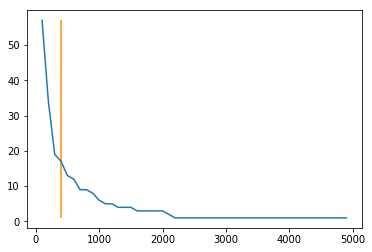

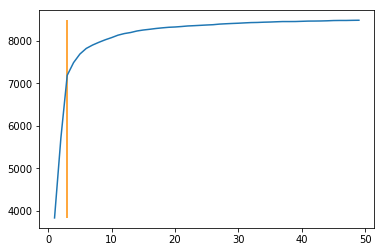

In [5]:
# Reduction potantial:

# High frequency words
high_freq = {}

high_range = np.arange(100,5000,100)

for i in high_range:
    temp_freq = []
    for k, v in dist.items():
        if v >= i:
            temp_freq.append(k)
    high_freq["freq"+str(i)] = len(temp_freq)

max_high = max(list(high_freq.values()))
min_high = min(list(high_freq.values()))
    
plt.plot(high_range, list(high_freq.values()))
plt.vlines(400, min_high,max_high, colors= "darkorange")

plt.show()


# Low frecuncy words
low_freq = {}

low_range = np.arange(1,50,1)

for i in low_range:
    temp_freq = []
    for k, v in dist.items():
        if v <= i:
            temp_freq.append(k)
    low_freq["freq"+str(i)] = len(temp_freq)

max_low = max(list(low_freq.values()))
min_low = min(list(low_freq.values()))

plt.plot(low_range, list(low_freq.values()))
plt.vlines(3, min_low,max_low, colors= "darkorange")

plt.show()

In [6]:
high_freq_remove = []
low_freq_remove = []

for i, j in dist.items():
    if j >= 400:
        high_freq_remove.append(i)
    elif j <= 3:
        low_freq_remove.append(i)
        
print(len(low_freq_remove))
print(len(high_freq_remove))

full_freq_remove = high_freq_remove + low_freq_remove

print(len(full_freq_remove))

7190
17
7207


In [7]:
# remove singeltons and doubles:
short = []

for i in words:
    if len(i)<=2:
        short.append(i)

short_remove = list(set(short))

full_remove = short_remove + full_freq_remove

Du skal havde sortere twitter adresser ud så som: https://t.co/jEM7KCz3uT 

and also all punktuation.. "..." seems to have escapaded you 

REGEX!

In [8]:
# A pickle for the word2vec implimentation
output = open('full_remove.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(full_remove, output)

output.close()

In [9]:
stop_words = []#["goptaxscam"] # for now no stopwords

def prep2(text):
    wordlist = nltk.word_tokenize(text)
    wordlist = [lemmatizer.lemmatize(w.lower()) for w in wordlist]
    wordlist = [w for w in wordlist if w not in full_remove and w not in stop_words]
    return wordlist

words_processed = prep2(df.text.to_string())
len(words_processed)

19479

In [10]:
# Can't pickle a function...
# A pickle for the word2vec implimentation
output = open('prep2.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(prep2, output)

output.close()

In [11]:
# For all text (why did you use wordF)
dist = nltk.FreqDist(words_processed)
print("all tweets:")
print(dist.most_common(20))
print("\n","-------------------")

all tweets:
[('you', 320), ('with', 290), ('goptaxscam', 289), ('great', 258), ('this', 248), ('will', 247), ('our', 243), ('tax', 225), ('today', 221), ('that', 215), ('are', 213), ('amp', 169), ('have', 168), ('thank', 161), ('http', 159), ('from', 150), ('just', 144), ('house', 133), ('republican', 126), ('all', 115)]

 -------------------


## Count vectorizer

In [12]:
unigram_vectorizer = CountVectorizer(tokenizer=prep2) 
bigram_vectorizer =  CountVectorizer(ngram_range=(2,2), tokenizer=prep2) 
trigram_vectorizer = CountVectorizer(ngram_range=(3,3), tokenizer=prep2)

X_train_dtm_1C = unigram_vectorizer.fit_transform(X_train) 
X_test_dtm_1C = unigram_vectorizer.transform(X_test)

X_dtm_1C = (X_train_dtm_1C, X_test_dtm_1C)

X_train_dtm_2C = bigram_vectorizer.fit_transform(X_train) 
X_test_dtm_2C = bigram_vectorizer.transform(X_test)

X_dtm_2C = (X_train_dtm_2C, X_test_dtm_2C)

X_train_dtm_3C = trigram_vectorizer.fit_transform(X_train) 
X_test_dtm_3C = trigram_vectorizer.transform(X_test)

X_dtm_3C = (X_train_dtm_3C, X_test_dtm_3C)

# --------------------------------------------

X_train_dtm_allC = sparse.hstack([X_train_dtm_1C, X_train_dtm_2C, X_train_dtm_3C])
X_test_dtm_allC = sparse.hstack([X_test_dtm_1C, X_test_dtm_2C, X_test_dtm_3C])

X_dtm_allC = (X_train_dtm_allC, X_test_dtm_allC)

# ------------------------------------------
X_dtm_C = [X_dtm_1C, X_dtm_2C, X_dtm_3C, X_dtm_allC]

In [13]:
unigram_featuresC = unigram_vectorizer.get_feature_names()
bigram_featuresC = bigram_vectorizer.get_feature_names()
trigram_featuresC = trigram_vectorizer.get_feature_names()

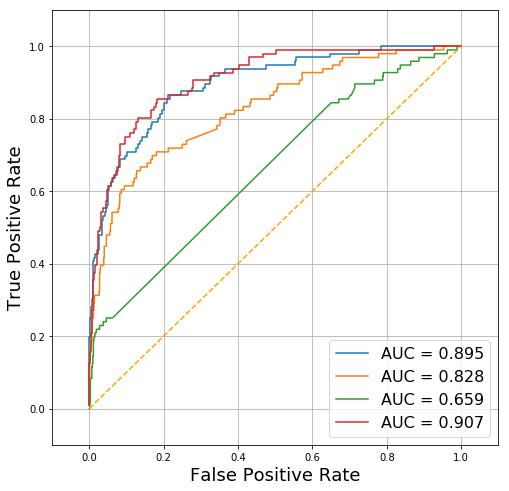

In [14]:
plt.figure(figsize=[8,8])

for i in X_dtm_C:
    clf_lg = LogisticRegression().fit(i[0], y_train)
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))


plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

## tf-idf vectorizer

In [15]:
unigram_vectorizer = TfidfVectorizer(tokenizer=prep2) 
bigram_vectorizer =  TfidfVectorizer(ngram_range=(2,2), tokenizer=prep2) 
trigram_vectorizer = TfidfVectorizer(ngram_range=(3,3), tokenizer=prep2)

X_train_dtm_1T = unigram_vectorizer.fit_transform(X_train) 
X_test_dtm_1T = unigram_vectorizer.transform(X_test)

X_dtm_1T = (X_train_dtm_1T, X_test_dtm_1T)


X_train_dtm_2T = bigram_vectorizer.fit_transform(X_train) 
X_test_dtm_2T = bigram_vectorizer.transform(X_test)

X_dtm_2T = (X_train_dtm_2T, X_test_dtm_2T)


X_train_dtm_3T = trigram_vectorizer.fit_transform(X_train) 
X_test_dtm_3T = trigram_vectorizer.transform(X_test)

X_dtm_3T = (X_train_dtm_3T, X_test_dtm_3T)

# -----------------------------------------------
X_train_dtm_allT = sparse.hstack([X_train_dtm_1T, X_train_dtm_2T, X_train_dtm_3T])
X_test_dtm_allT = sparse.hstack([X_test_dtm_1T, X_test_dtm_2T, X_test_dtm_3T])

X_dtm_allT = (X_train_dtm_allT, X_test_dtm_allT)

# ------------------------------------------

X_dtm_T = [X_dtm_1T, X_dtm_2T, X_dtm_3T, X_dtm_allT]

In [16]:
unigram_featuresT = unigram_vectorizer.get_feature_names()
bigram_featuresT = bigram_vectorizer.get_feature_names()
trigram_featuresT = trigram_vectorizer.get_feature_names()

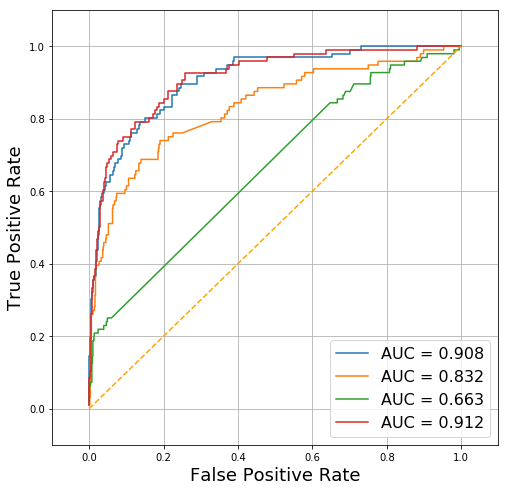

In [17]:
plt.figure(figsize=[8,8])

for i in X_dtm_T:
    clf_lg = LogisticRegression().fit(i[0], y_train)
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))


plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

## Combined

In [18]:
X_train_dtm_all = sparse.hstack([X_train_dtm_allT, X_train_dtm_allC])
X_test_dtm_all = sparse.hstack([X_test_dtm_allT, X_test_dtm_allC])

X_dtm_all = (X_train_dtm_all, X_test_dtm_all)

X_dtm = [X_dtm_all]

In [19]:
features_vector = unigram_featuresC + bigram_featuresC + trigram_featuresC +unigram_featuresT + bigram_featuresT + trigram_featuresT

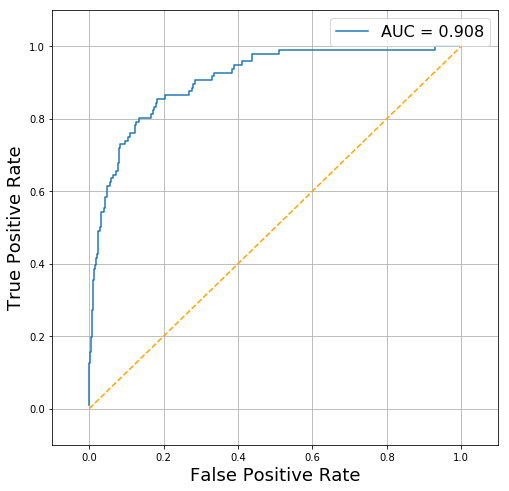

In [20]:
plt.figure(figsize=[8,8])

for i in X_dtm:
    clf_lg = LogisticRegression().fit(i[0], y_train)
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))


plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

In [21]:
X_train_dtm_all.shape

(3263, 119450)

## Conclusion
So for the BoW, if you should choose one, you should choose td-idf with 1,2,3 - grams 
men det kommer self også an på hvor lang tid sk feature selection tager?

----
# Number of !, ?, @, and # (and emojis?)

In [22]:
def count_symb(X):
    count_att = []
    count_exclamation = []
    count_question = []
    count_hashtags = []

    for i in X:
        count_att.append(i.count("@"))
        count_exclamation.append(i.count("!"))
        count_question.append(i.count("?"))
        count_hashtags.append(i.count("#"))

    count_df = pd.DataFrame([count_att,count_exclamation,count_question,count_hashtags]).T
    count_df.columns = {"count_att":0,"count_exclamation":1,"count_question":2,"count_hashtags":3}

    return(sparse.csr_matrix(count_df))
    

In [23]:
count_features = ["count_att","count_exclamation","count_question","count_hashtags"]
features_vector = features_vector + count_features

In [24]:
X_train_count_symb = count_symb(X_train)
X_test_count_symb = count_symb(X_test)

In [25]:
X_train_dtm_all_count = sparse.hstack([X_train_dtm_all, X_train_count_symb])
X_test_dtm_all_count = sparse.hstack([X_test_dtm_all, X_test_count_symb])

In [26]:
X_dtm_all_count = (X_train_dtm_all_count, X_test_dtm_all_count)
X_dtm_count = [X_dtm_all_count]

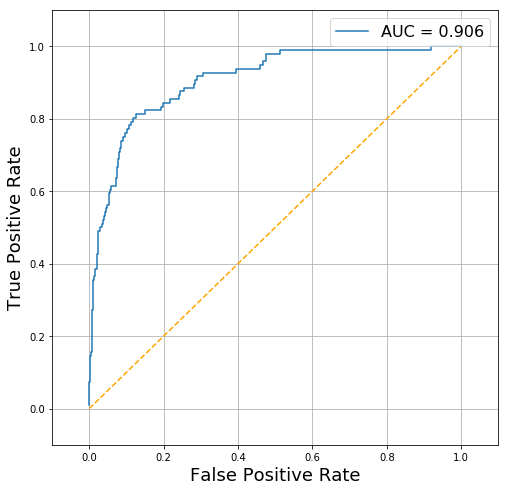

In [27]:
plt.figure(figsize=[8,8])

for i in X_dtm_count:
    clf_lg = LogisticRegression().fit(i[0], y_train)
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))


plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

# Features from word2vec

## Make the word2vec model

In [28]:
df_unlabled_big = pd.read_csv("/media/polichinel/DATA/backup/PDS_DATA/new_many_tweets.csv", index_col= 0)
df_unlabled = pd.read_csv("all_unlabled_tweets.csv", index_col= 0)
df_labled = pd.read_csv("labled_tweets.csv", index_col= 0)

pkl_file = open('full_remove.pkl', 'rb') # from feature set.
full_remove = pickle.load(pkl_file)
pkl_file.close()

/home/polichinel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,1,4,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
# should be enough - check before deleting the direct implimentation

pkl_file = open('prep2.pkl', 'rb') # from feature set.
prep2 = pickle.load(pkl_file)
pkl_file.close()

In [30]:
def check_model(model, most_sim = "president"):
    print("Most similar to {}:\n".format(most_sim))
    for i in model.wv.most_similar(most_sim):
        print(i)

    print("\n")
    # get the Most common words
    print("Most common words:")
    print(model.wv.index2word[0], model.wv.index2word[1], model.wv.index2word[2])

    print("\n")
    # get the least common words
    vocab_size = len(model.wv.vocab)
    print("Least common words:")
    print(model.wv.index2word[vocab_size - 1], model.wv.index2word[vocab_size - 2], model.wv.index2word[vocab_size - 3])

    print("\n")
    # some similarity fun
    print("Sanity sim check1:")
    print(model.wv.similarity('woman', 'man'), model.wv.similarity('woman', 'thing'))

    print("\n")
    print("Sanity sim check2:")
    # what doesn't fit?
    print(model.wv.doesnt_match("green blue red man".split()))

In [31]:
path = "/media/polichinel/DATA/backup/PDS_DATA/"

In [32]:
spec_path = path + "hot_comments_politics.pkl"


pkl_file = open(spec_path, 'rb') # from feature set.
comments1 = pickle.load(pkl_file)
pkl_file.close()

In [33]:
spec_path = path + "controversial_comments_politics.pkl"

pkl_file = open(spec_path, 'rb') # from feature set.
comments2 = pickle.load(pkl_file)
pkl_file.close()

In [34]:
spec_path = path + "hot_comments_news.pkl"

pkl_file = open(spec_path, 'rb') # from feature set.
comments3 = pickle.load(pkl_file)
pkl_file.close()

In [35]:
spec_path = path + "controversial_comments_news.pkl"

pkl_file = open(spec_path, 'rb') # from feature set.
comments4 = pickle.load(pkl_file)
pkl_file.close()

In [36]:
spec_path = path + "top_comments_politics.pkl"


pkl_file = open(spec_path, 'rb') # from feature set.
comments5 = pickle.load(pkl_file)
pkl_file.close()


In [37]:
spec_path = path + "top_comments_news.pkl"


pkl_file = open(spec_path, 'rb') # from feature set.
comments6 = pickle.load(pkl_file)
pkl_file.close()

In [38]:
comments_all = comments1 + comments2 + comments3 + comments4 + comments5 + comments6
all_text = comments_all + list(df_unlabled_big.text) + list(df_unlabled.text)

In [39]:
len(all_text)

1947563

In [40]:
# this time we set a bit more options:

# Set values for various parameters
feature_size = 300    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 10   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


# tweets are back from 140 character limit; not 240!
sentences = [prep2(sent) for sent in nltk.sent_tokenize(pd.Series(all_text).to_string())]
model = gensim.models.Word2Vec(sentences, size=feature_size, window=window_context, min_count=min_word_count, sample=sample, iter=50)
                               
len(list(model.wv.vocab.keys())) # Men, med min_count = 10 har du kun 1650 obs... Flere tweets mere text.

30339

In [41]:
check_model(model, "president")

Most similar to president:

('pres', 0.5604985952377319)
('administration', 0.5250197052955627)
('presi', 0.44312191009521484)
('potus', 0.4355844557285309)
('admin', 0.4201052784919739)
('trump', 0.4143386781215668)
('donald', 0.4111642837524414)
('realdonaldtrump', 0.32334235310554504)
('appointee', 0.32304877042770386)
('obama', 0.31245604157447815)


Most common words:
that you this


Least common words:
peterwsj bkesling usafmatthew


Sanity sim check1:
0.08044655596077459 -0.0645665534312646


Sanity sim check2:
man


In [42]:
output = open('word2vec_model.pkl', 'wb')
pickle.dump(model, output)
output.close()

## Making the features

### First try (not working)

In [43]:
# get your model

pkl_file = open('word2vec_model.pkl', 'rb') # from feature set.
#pkl_file = open('word2vec_small_model.pkl', 'rb') # from feature set.

word2vec_model = pickle.load(pkl_file)
pkl_file.close()

In [107]:
n_features = word2vec_model.wv.word_vec("potus").shape[0]

In [108]:
w2v_train_df = pd.DataFrame(np.zeros([len(X_train),n_features]))
vectors = np.zeros(n_features)
dividend = 0

for i in range(len(X_train)):
    strings = X_train.iloc[i].split()
    for j in range(len(strings)):
        word = prep2(strings[j].lower())
        if len(word) > 0:
            clean_word = re.sub(r'[^\w\s]','',word[0])
            #print(clean_word, "\n")
            #print(word2vec_model.wv.word_vec(clean_word))
            if clean_word in list(word2vec_model.wv.vocab):
                dividend += 1
                vectors += word2vec_model.wv.word_vec(clean_word)
        
    mean_vector = vectors/dividend
    w2v_train_df.iloc[i] = mean_vector

In [111]:
w2v_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.054399,-0.898926,0.366477,1.474878,-0.900951,0.215470,-0.427083,-0.019338,-0.308580,0.112684,...,-0.317979,-0.765928,-0.230627,-0.928105,0.258100,0.850678,-1.073145,-0.380913,-1.238278,-0.703060
1,-0.118097,-0.517376,0.418401,1.599083,-0.414631,-0.044689,-0.132942,-0.515248,-0.316393,0.141132,...,-0.376936,-0.679211,-0.223088,-0.584346,0.331547,0.438669,-1.001409,0.152299,-1.411715,-0.419760
2,-0.266468,0.175031,0.142671,0.542173,-0.055883,-0.009757,0.068094,-0.315659,-0.945029,0.079980,...,-0.089468,-0.316280,-0.621526,-0.365829,0.406753,0.450030,0.040060,0.359943,-1.052686,0.006169
3,-0.384984,0.086131,-0.053504,0.472877,-0.049518,0.065902,0.072099,-0.481808,-0.933006,0.165997,...,-0.102197,-0.308860,-0.626188,-0.543091,0.435718,0.335343,-0.193805,0.318428,-0.961121,-0.091430
4,-0.376066,-0.056726,-0.232528,0.522390,0.077525,0.040446,0.052248,-0.617200,-1.000260,0.292429,...,0.151570,-0.258384,-0.620569,-0.304264,-0.238428,0.544539,-0.105061,0.154807,-0.783021,-0.083971


In [109]:
w2v_test_df = pd.DataFrame(np.zeros([len(X_test),n_features]))
vectors = np.zeros(n_features)
dividend = 0

for i in range(len(X_test)):
    strings = X_test.iloc[i].split()
    for j in range(len(strings)):
        word = prep2(strings[j].lower())
        if len(word) > 0:
            clean_word = re.sub(r'[^\w\s]','',word[0])
            #print(clean_word, "\n")
            #print(word2vec_model.wv.word_vec(clean_word))
            if clean_word in list(word2vec_model.wv.vocab):
                dividend += 1
                vectors += word2vec_model.wv.word_vec(clean_word)
        
    mean_vector = vectors/dividend
    w2v_test_df.iloc[i] = mean_vector

In [110]:
w2v_test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.129012,-0.126241,0.185017,-0.299243,0.190867,0.649260,0.943147,0.298890,0.164166,0.768667,...,0.385067,0.758326,-0.739136,-0.519583,0.978376,0.913047,-0.336684,-0.781262,-0.403395,-0.097971
1,-0.407616,-0.152013,0.483244,-0.812976,0.216882,0.349498,0.868853,0.474934,0.310708,0.527099,...,0.312568,1.144058,-0.606680,-0.449201,0.784710,0.983268,-0.073827,-0.847251,-0.342786,-0.429889
2,-0.502167,0.017439,-0.426210,-0.764616,0.342228,0.201179,0.352663,0.418677,0.070173,-0.021412,...,0.442439,0.706595,-0.686985,-0.538560,0.397683,0.790759,-0.205856,-0.214272,-0.156618,-0.264870
3,-0.487762,-0.029774,-0.064618,-0.498689,0.244093,0.081686,0.120687,0.252304,-0.259543,-0.116100,...,0.473880,0.472537,-0.448047,-0.376795,0.504689,0.683972,-0.129912,-0.097575,-0.126640,-0.490386
4,-0.551309,-0.214633,-0.137186,-0.408829,0.197125,0.024706,0.064108,0.286156,0.044353,-0.061299,...,0.348141,0.430672,-0.383804,-0.138204,0.479966,0.514904,0.053981,-0.319977,-0.205298,-0.438004


In [47]:
# Stupid framework you have created:
X_w2v = (w2v_train_df, w2v_test_df)
X_w2v_list = [X_w2v]

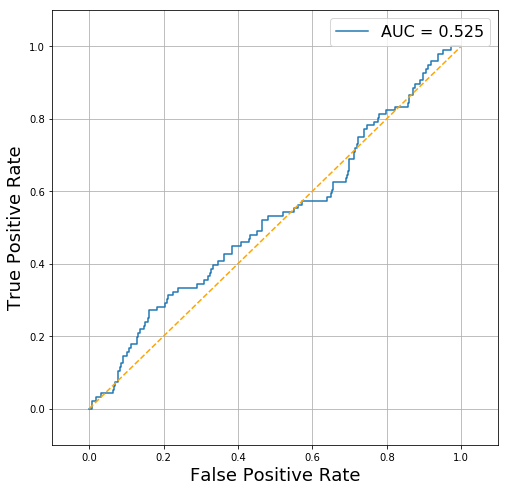

In [48]:
plt.figure(figsize=[8,8])

for i in X_w2v_list:
    clf_lg = LogisticRegression().fit(i[0], y_train)
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))


plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

Well. Still not imprassing

# Second try (Working!)

In [128]:
from scipy import spatial

index2word_set = set(word2vec_model.wv.index2word)

def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return(feature_vec)



In [129]:
# test
s1_afv = avg_feature_vector('this is a sentence', model=word2vec_model, num_features=n_features, index2word_set=index2word_set)
s2_afv = avg_feature_vector('this is also sentence', model=word2vec_model, num_features=n_features, index2word_set=index2word_set)
sim = 1 - spatial.distance.cosine(s1_afv, s2_afv)
print(sim)

0.9136499762535095


/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [130]:
w2v_train_df_new = pd.DataFrame(np.zeros([len(X_train),n_features]))
vectors = np.zeros(n_features)
dividend = 0


for i in range(len(X_train)):
    test_sent_list = []
    strings = X_train.iloc[i].split()
    for j in range(len(strings)):
        word = prep2(strings[j].lower())
        if len(word) > 0:
            clean_word = re.sub(r'[^\w\s]','',word[0])
            test_sent_list.append(clean_word)
            test_sent = " ".join(test_sent_list)
            
            w2v_train_df_new.iloc[i] = avg_feature_vector(test_sent, model=word2vec_model, num_features=n_features, index2word_set=index2word_set)

/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [131]:
w2v_train_df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.054399,-0.898926,0.366477,1.474878,-0.900951,0.215470,-0.427083,-0.019338,-0.308580,0.112684,...,-0.317979,-0.765928,-0.230627,-0.928105,0.258100,0.850678,-1.073145,-0.380913,-1.238278,-0.703060
1,-0.245493,0.245725,0.522250,1.847493,0.558010,-0.565006,0.455341,-1.507068,-0.332018,0.198027,...,-0.494849,-0.505776,-0.208011,0.103173,0.478442,-0.385349,-0.857936,1.218723,-1.758589,0.146842
2,-0.444513,1.005919,-0.188205,-0.726119,0.374615,0.032162,0.309337,-0.076153,-1.699392,0.006598,...,0.255494,0.119236,-1.099652,-0.103608,0.496999,0.463664,1.289823,0.609116,-0.621852,0.517283
3,-1.362741,-0.647295,-1.671946,-0.098810,0.002994,0.690086,0.105136,-1.852529,-0.833816,0.875632,...,-0.207212,-0.247647,-0.664646,-2.005501,0.674683,-0.610824,-2.123199,-0.024068,-0.205705,-0.896620
4,-0.346067,-0.537244,-0.834701,0.688931,0.504850,-0.045177,-0.014521,-1.072612,-1.226481,0.717702,...,1.005148,-0.088601,-0.601670,0.499063,-2.506010,1.248196,0.193442,-0.395556,-0.183957,-0.058882


In [132]:
w2v_X_test_df_new = pd.DataFrame(np.zeros([len(X_test),n_features]))
vectors = np.zeros(n_features)
dividend = 0


for i in range(len(X_test)):
    test_sent_list = []
    strings = X_test.iloc[i].split()
    for j in range(len(strings)):
        word = prep2(strings[j].lower())
        if len(word) > 0:
            clean_word = re.sub(r'[^\w\s]','',word[0])
            test_sent_list.append(clean_word)
            test_sent = " ".join(test_sent_list)
            
            w2v_test_df_new.iloc[i] = avg_feature_vector(test_sent, model=word2vec_model, num_features=n_features, index2word_set=index2word_set)

/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [133]:
w2v_test_df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.129012,-0.126241,0.185017,-0.299243,0.190867,0.649260,0.943147,0.298890,0.164166,0.768667,...,0.385067,0.758326,-0.739137,-0.519583,0.978376,0.913047,-0.336684,-0.781262,-0.403395,-0.097971
1,-0.797661,-0.188093,0.900762,-1.532202,0.253304,-0.070168,0.764842,0.721396,0.515865,0.188904,...,0.211069,1.684082,-0.421241,-0.350667,0.513577,1.081578,0.294172,-0.939634,-0.257934,-0.894575
2,-0.676722,0.330274,-2.105202,-0.675335,0.573635,-0.072640,-0.600303,0.314819,-0.373891,-1.034047,...,0.682201,-0.101029,-0.835240,-0.703531,-0.316828,0.435358,-0.449602,0.954304,0.187077,0.039781
3,-0.449692,-0.154554,0.891019,0.204117,-0.015264,-0.234119,-0.492392,-0.187396,-1.130936,-0.366347,...,0.556976,-0.146045,0.183433,0.050728,0.787491,0.401750,0.070797,0.210838,-0.047412,-1.086392
4,-0.782801,-0.888046,-0.401542,-0.081482,0.026026,-0.182862,-0.142001,0.409472,1.151403,0.138334,...,-0.109910,0.278164,-0.149776,0.730950,0.389905,-0.100986,0.723878,-1.130154,-0.491837,-0.247186


In [134]:
# Stupid framework you have created:
X_w2v_new = (w2v_train_df_new, w2v_test_df_new)
X_w2v_list_new = [X_w2v_new]

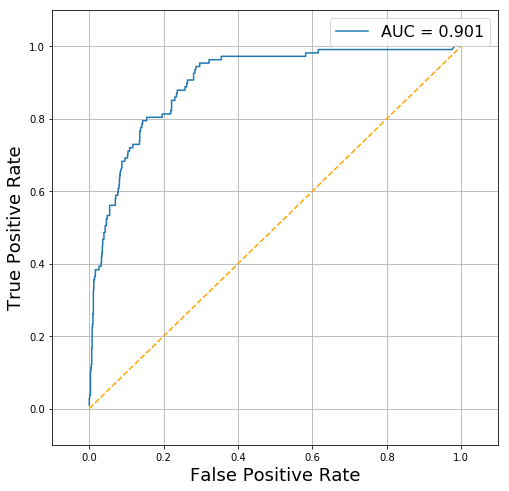

In [135]:
plt.figure(figsize=[8,8])

for i in X_w2v_list_new:
    clf_lg = LogisticRegression().fit(i[0], y_train)
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))


plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

### merge with full set

In [136]:
# yeah, a unprudent reuse, but it'll do
X_train_dtm_all_count = sparse.hstack([X_train_dtm_all_count, w2v_train_df_new])
X_test_dtm_all_count = sparse.hstack([X_test_dtm_all_count, w2v_test_df_new])

X_dtm_all_count = (X_train_dtm_all_count, X_test_dtm_all_count)
X_dtm_count = [X_dtm_all_count]

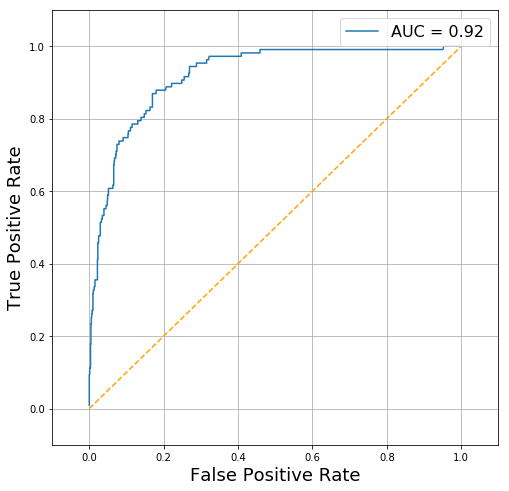

In [137]:
plt.figure(figsize=[8,8])

for i in X_dtm_count:
    clf_lg = LogisticRegression().fit(i[0], y_train)
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))


plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

# Oversample test:

In [138]:
ros = RandomOverSampler(random_state=42)
sos = SMOTE(random_state=42)

X_dtm_all_count_train_Roversampled, y_Roversampled = ros.fit_sample(X_dtm_all_count[0], y_train)
X_dtm_all_count_train_Soversampled, y_Soversampled = sos.fit_sample(X_dtm_all_count[0], y_train)

X_dtm_all_count_Rover = (X_dtm_all_count_train_Roversampled, X_test_dtm_all_count)
X_dtm_all_count_Sover = (X_dtm_all_count_train_Soversampled, X_test_dtm_all_count)



X_dtm_samples = [X_dtm_all_count_Rover,X_dtm_all_count_Sover]
y_samples = [y_Roversampled,y_Soversampled]

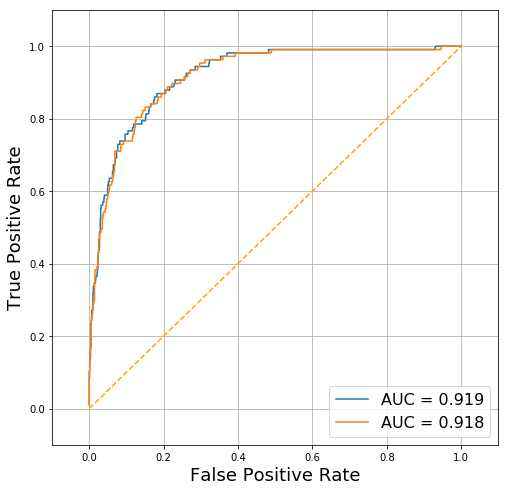

In [139]:
plt.figure(figsize=[8,8])

for i in X_dtm_samples:
    c = 0
    clf_lg = LogisticRegression().fit(i[0], y_samples[c])
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))
    c += 1

plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

# Feature importance - for word2vec mayhaps

In [141]:
# clf_rf = RandomForestClassifier(random_state=42).fit(X_dtm_all_count_train_Roversampled, y_Roversampled)
# importances = clf_rf.feature_importances_
# indices = np.argsort(importances)[::-1]

# #Print the feature ranking
# print("Feature ranking:")
# print(20*"-")
# for f in range(10):
#     print("{}. feature number: {}\n\tstring: {}\n\tImportance: {}\n". format(f+1, indices[f], features_vector[indices[f]], importances[indices[f]]))

# Feature Selection

In [53]:
# What we startout with

In [142]:
X_dtm_all_count_train_Roversampled.shape

(7288, 146294)

In [143]:
len(features_vector) # checks óut. Hope it is in the right order..

119454

In [144]:
clf_lg = LogisticRegression().fit(X_dtm_all_count_train_Roversampled, y_Roversampled)

model = SelectFromModel(clf_lg, prefit=True)
X_new_train = model.transform(X_dtm_all_count_train_Roversampled) #It works becouse you have allready fitted the logistic regression on the trainset
print(X_new_train.shape)

X_new_test = model.transform(X_test_dtm_all_count) #It works becouse you have allready fitted the logistic regression on the trainset
print(X_new_test.shape)

(7288, 33833)
(1020, 33833)


In [145]:
X_dtm_all_count_Rover_LF = (X_new_train, X_new_test)

X_dtm_samples = [X_dtm_all_count_Rover,X_dtm_all_count_Rover_LF]
y_samples = [y_Roversampled,y_Roversampled]

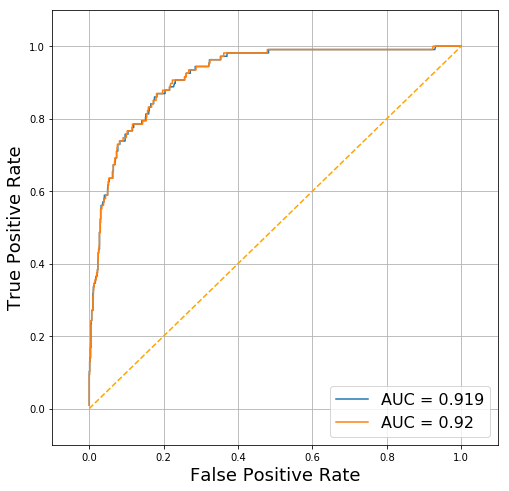

In [146]:


plt.figure(figsize=[8,8])

for i in X_dtm_samples:
    c = 0
    clf_lg = LogisticRegression().fit(i[0], y_samples[c])
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))
    c += 1

plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()
    

# Singular Value Dicomposition

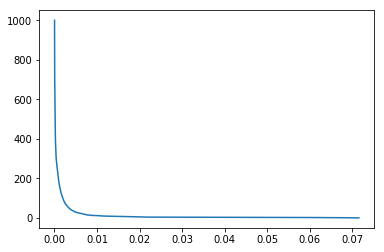

311


In [147]:
n_comp = 1000 # Fordi eller tager det en krig

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=n_comp, n_iter=10, random_state=42)
svd.fit(X_new_train)

# ------------------------------------------------------------------

svd_exp_var = sorted(svd.explained_variance_ratio_, reverse = True) # should be sotred, but now we are sure
svd_range = np.linspace(0,len(svd_exp_var),n_comp)
plt.plot(svd_exp_var,svd_range)
# xticks

plt.show()

# -----------------------------------------------------------------

c = 0

for c in range(0,1000):
    if svd.explained_variance_ratio_[:c].sum() >= 0.90:
        print(c)
        break


# --------------------------------------------------------------
        
n_comp = c # et her kunne være fedt at gøre mere systematisk..

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=n_comp, n_iter=10, random_state=42)
svd.fit(X_new_train)
        
svd_train = svd.transform(X_new_train)
svd_test = svd.transform(X_new_test)
# her mangler da noget?

In [148]:
print(svd_train.shape)
print(svd_test.shape)

(7288, 311)
(1020, 311)


In [149]:
X_svd = (svd_train, svd_test)

X_dtm_samples = [X_dtm_all_count_Rover_LF,X_svd]
y_samples = [y_Roversampled,y_Roversampled]

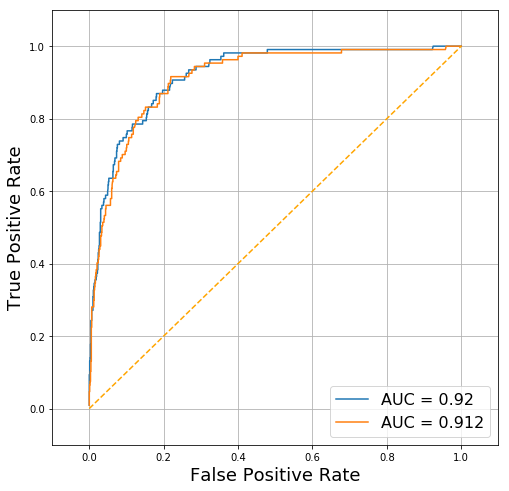

In [150]:

plt.figure(figsize=[8,8])

for i in X_dtm_samples:
    c = 0
    clf_lg = LogisticRegression().fit(i[0], y_samples[c])
    pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
    auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    plt.plot(fpr, tpr, label = "AUC = " + str(auc))
    c += 1

plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.grid(True)

plt.legend(fontsize = 16)
#sns.despine(left=True, bottom= True)

plt.savefig('roc_all_new.pdf', bbox_inches="tight")

plt.show()

# Impliment on train_out and test_out:

In [151]:
#This is not nessecery, but it's a precoursion
del X_train, X_test, y_train, y_test

In [152]:
X_train = X_train_out
X_test = X_test_out
y_train = y_train_out
y_test = y_test_out


In [153]:
unigram_vectorizer = CountVectorizer(tokenizer=prep2) 
bigram_vectorizer =  CountVectorizer(ngram_range=(2,2), tokenizer=prep2) 
trigram_vectorizer = CountVectorizer(ngram_range=(3,3), tokenizer=prep2)

X_train_dtm_1C = unigram_vectorizer.fit_transform(X_train) 
X_test_dtm_1C = unigram_vectorizer.transform(X_test)

X_dtm_1C = (X_train_dtm_1C, X_test_dtm_1C)

X_train_dtm_2C = bigram_vectorizer.fit_transform(X_train) 
X_test_dtm_2C = bigram_vectorizer.transform(X_test)

X_dtm_2C = (X_train_dtm_2C, X_test_dtm_2C)

X_train_dtm_3C = trigram_vectorizer.fit_transform(X_train) 
X_test_dtm_3C = trigram_vectorizer.transform(X_test)

X_dtm_3C = (X_train_dtm_3C, X_test_dtm_3C)

# --------------------------------------------

X_train_dtm_allC = sparse.hstack([X_train_dtm_1C, X_train_dtm_2C, X_train_dtm_3C])
X_test_dtm_allC = sparse.hstack([X_test_dtm_1C, X_test_dtm_2C, X_test_dtm_3C])

X_dtm_allC = (X_train_dtm_allC, X_test_dtm_allC)

# ------------------------------------------
X_dtm_C = [X_dtm_1C, X_dtm_2C, X_dtm_3C, X_dtm_allC]

In [154]:
unigram_vectorizer = TfidfVectorizer(tokenizer=prep2) 
bigram_vectorizer =  TfidfVectorizer(ngram_range=(2,2), tokenizer=prep2) 
trigram_vectorizer = TfidfVectorizer(ngram_range=(3,3), tokenizer=prep2)

X_train_dtm_1T = unigram_vectorizer.fit_transform(X_train) 
X_test_dtm_1T = unigram_vectorizer.transform(X_test)

X_dtm_1T = (X_train_dtm_1T, X_test_dtm_1T)


X_train_dtm_2T = bigram_vectorizer.fit_transform(X_train) 
X_test_dtm_2T = bigram_vectorizer.transform(X_test)

X_dtm_2T = (X_train_dtm_2T, X_test_dtm_2T)


X_train_dtm_3T = trigram_vectorizer.fit_transform(X_train) 
X_test_dtm_3T = trigram_vectorizer.transform(X_test)

X_dtm_3T = (X_train_dtm_3T, X_test_dtm_3T)

# -----------------------------------------------
X_train_dtm_allT = sparse.hstack([X_train_dtm_1T, X_train_dtm_2T, X_train_dtm_3T])
X_test_dtm_allT = sparse.hstack([X_test_dtm_1T, X_test_dtm_2T, X_test_dtm_3T])

X_dtm_allT = (X_train_dtm_allT, X_test_dtm_allT)

# ------------------------------------------

X_dtm_T = [X_dtm_1T, X_dtm_2T, X_dtm_3T, X_dtm_allT]

In [155]:
X_train_dtm_all = sparse.hstack([X_train_dtm_allT, X_train_dtm_allC])
X_test_dtm_all = sparse.hstack([X_test_dtm_allT, X_test_dtm_allC])

X_dtm_all = (X_train_dtm_all, X_test_dtm_all)

X_dtm = [X_dtm_all]

In [156]:
X_train_count_symb = count_symb(X_train)
X_test_count_symb = count_symb(X_test)

X_train_dtm_all_count = sparse.hstack([X_train_dtm_all, X_train_count_symb])
X_test_dtm_all_count = sparse.hstack([X_test_dtm_all, X_test_count_symb])

X_dtm_all_count = (X_train_dtm_all_count, X_test_dtm_all_count)
X_dtm_count = [X_dtm_all_count]

In [157]:
w2v_train_df_new = pd.DataFrame(np.zeros([len(X_train),n_features]))
vectors = np.zeros(n_features)
dividend = 0


for i in range(len(X_train)):
    test_sent_list = []
    strings = X_train.iloc[i].split()
    for j in range(len(strings)):
        word = prep2(strings[j].lower())
        if len(word) > 0:
            clean_word = re.sub(r'[^\w\s]','',word[0])
            test_sent_list.append(clean_word)
            test_sent = " ".join(test_sent_list)
            
            w2v_train_df_new.iloc[i] = avg_feature_vector(test_sent, model=word2vec_model, num_features=n_features, index2word_set=index2word_set)


w2v_X_test_df_new = pd.DataFrame(np.zeros([len(X_test),n_features]))
vectors = np.zeros(n_features)
dividend = 0


for i in range(len(X_test)):
    test_sent_list = []
    strings = X_test.iloc[i].split()
    for j in range(len(strings)):
        word = prep2(strings[j].lower())
        if len(word) > 0:
            clean_word = re.sub(r'[^\w\s]','',word[0])
            test_sent_list.append(clean_word)
            test_sent = " ".join(test_sent_list)
            
            w2v_test_df_new.iloc[i] = avg_feature_vector(test_sent, model=word2vec_model, num_features=n_features, index2word_set=index2word_set)

# Stupid framework you have created:
X_w2v_new = (w2v_train_df_new, w2v_test_df_new)
X_w2v_list_new = [X_w2v_new]


# yeah, a unprudent reuse, but it'll do
X_train_dtm_all_count = sparse.hstack([X_train_dtm_all_count, w2v_train_df_new])
X_test_dtm_all_count = sparse.hstack([X_test_dtm_all_count, w2v_test_df_new])

X_dtm_all_count = (X_train_dtm_all_count, X_test_dtm_all_count)
X_dtm_count = [X_dtm_all_count]

/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [158]:
# You don't end up using smote... But leave it here for now.
ros = RandomOverSampler(random_state=42)
sos = SMOTE(random_state=42)

X_dtm_all_count_train_Roversampled, y_Roversampled = ros.fit_sample(X_dtm_all_count[0], y_train)
X_dtm_all_count_train_Soversampled, y_Soversampled = sos.fit_sample(X_dtm_all_count[0], y_train)

X_dtm_all_count_Rover = (X_dtm_all_count_train_Roversampled, X_test_dtm_all_count)
X_dtm_all_count_Sover = (X_dtm_all_count_train_Soversampled, X_test_dtm_all_count)



X_dtm_samples = [X_dtm_all_count_Rover,X_dtm_all_count_Sover]
y_samples = [y_Roversampled,y_Soversampled]

In [159]:
X_dtm_all_count_train_Roversampled.shape

(7288, 146294)

In [160]:
clf_lg = LogisticRegression().fit(X_dtm_all_count_train_Roversampled, y_Roversampled)

model = SelectFromModel(clf_lg, prefit=True)
X_new_train = model.transform(X_dtm_all_count_train_Roversampled) #It works becouse you have allready fitted the logistic regression on the trainset
print(X_new_train.shape)

X_new_test = model.transform(X_test_dtm_all_count) #It works becouse you have allready fitted the logistic regression on the trainset
print(X_new_test.shape)

(7288, 33833)
(1020, 33833)


In [161]:
X_dtm_all_count_Rover_LF = (X_new_train, X_new_test)

X_dtm_samples = [X_dtm_all_count_Rover,X_dtm_all_count_Rover_LF]
y_samples = [y_Roversampled,y_Roversampled]

In [162]:
n_comp = 1000 # Fordi eller tager det en krig

svd = TruncatedSVD(n_components=n_comp, n_iter=10, random_state=42)
svd.fit(X_new_train)

# ------------------------------------------------------------------

# svd_exp_var = sorted(svd.explained_variance_ratio_, reverse = True) # should be sotred, but now we are sure
# svd_range = np.linspace(0,len(svd_exp_var),n_comp)
# plt.plot(svd_exp_var,svd_range)
# # xticks

# plt.show()

# -----------------------------------------------------------------

c = 0

for c in range(0,1000):
    if svd.explained_variance_ratio_[:c].sum() >= 0.90:
        print(c)
        break


# --------------------------------------------------------------
        
n_comp = c # et her kunne være fedt at gøre mere systematisk..

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=n_comp, n_iter=10, random_state=42)
svd.fit(X_new_train)
        
svd_train = svd.transform(X_new_train)
svd_test = svd.transform(X_new_test)

311


In [163]:
X_svd = (svd_train, svd_test)

X_dtm_samples = [X_dtm_all_count_Rover_LF,X_svd]
y_samples = [y_Roversampled,y_Roversampled]

In [164]:
print("Non SVD")
print(X_dtm_all_count_Rover_LF[0].shape)
print(X_dtm_all_count_Rover_LF[1].shape)

print("\nSVD")
print(svd_train.shape)
print(svd_test.shape)

print("\nTarget")
print(y_Roversampled.shape)
print(y_test.shape)

Non SVD
(7288, 33833)
(1020, 33833)

SVD
(7288, 311)
(1020, 311)

Target
(7288,)
(1020,)


# Pickle it!

In [165]:
data_svd = {"y_test" : y_test,"y_train" : y_Roversampled, "X_train" : svd_train, "X_test" : svd_test}
data_non_svd = {"y_test" : y_test,"y_train" : y_Roversampled, "X_train" : X_dtm_all_count_Rover_LF[0], "X_test" : X_dtm_all_count_Rover_LF[1]}

In [166]:
output = open('data_svd.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(data_svd, output)

output.close()


In [167]:
output = open('data_non_svd.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(data_non_svd, output)

output.close()

### Done